In [1]:
import requests
import json
import re
import pandas as pd
import numpy as np
from itertools import chain
from matplotlib import pyplot as plt

In [2]:
def get_assessment(url):
    global count
    print(count)
    print(url)

    fes_collection_api = "https://w3id.org/FAIR_Evaluator/collections/6/evaluate"

    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json"
    }

    payload = {
        "resource": url,
        "executor": "mwurzb",
        "title": "comp_doi_test"
    }

    response = requests.post(fes_collection_api, headers=headers, json=payload)
    response_json = response.json()
    eval_result = json.loads(response_json.get("evaluationResult"))
    count = count + 1
    print("_________________________")
    return eval_result

In [3]:
def get_metricurl(url):
    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json"
    }

    response = requests.get(url=url, headers=headers)
    return response

In [4]:
def get_metrics_and_scores(eval_result):
    eval_result_keys = eval_result.keys()
    results = []
    metrics = []
    for k in eval_result_keys:
        metric_url = get_metricurl(k).json().get("test_of_metric")
        metric_abbrev = re.search(r'(?<=Gen2_FM_).*$', metric_url)
        metric = metric_abbrev.group()
        if metric in metrics:
            metric = metric + "b"
        else:
            metrics.append(metric)
            metric = metric + "a"

        eval_result_val = eval_result.get(k)
        key = "http://semanticscience.org/resource/SIO_000300"
        metric_score = int(eval_result_val[0][key][0]["@value"])

        results.append(
            {
                "metric": metric,
                "score": metric_score
            }
        )
    return results

In [5]:
def get_metrics_from_result(assessment_result):
    return [item.get('metric') for item in assessment_result]

def get_scores_from_result(assessment_result):
    return [int(item.get('score')) for item in assessment_result]

In [6]:
def print_summary_stats(scores):
    print("Mean: "+str(scores.mean()))
    print("Median: "+str(+scores.median()))
    print("Min: "+str(scores.min()))
    print("Max: "+str(scores.max()))

In [7]:
def get_principle_from_metric(metric):
    if metric.startswith("F"):
        return "findable"
    elif metric.startswith("A"):
        return "accessible"
    elif metric.startswith("I"):
        return "interoperable"
    else:
        return "reusable"

In [18]:
def adjust_metric_names(mname):
    if mname == "FA2a":
        return "A2a"
    return mname

# Papers

In [ ]:
def expand_paper_assessment_result(df):
    df_exp = pd.DataFrame()
    df_exp["paper"] = list(chain.from_iterable([[x]*22 for x in df["comparisons"]]))
    try:
        df_exp["doi"] = list(chain.from_iterable([[x]*22 for x in df["doi"]]))
    except KeyError:
        pass
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["assessment_result"]]))
    df_exp["score"] = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in df["assessment_result"]]))
    df_exp = df_exp[["comparison", "doi", "metric", "score"]]
    return df_exp

## Papers via DOI

### Papers assessment via DOI

In [ ]:
paper_doi_df = pd.read_csv("raw_data/orkg_papers_2023-03-29.csv", index_col=0)
paper_doi_df = paper_doi_df[paper_doi_df["doi"].isna() == False].reset_index(drop=True)
count = 0
paper_doi_df["assessment_result"] = paper_doi_df["doi"].map(lambda x: get_assessment(url="https://doi.org/" + x))
paper_doi_df["assessment_result"] = paper_doi_df["assessment_result"].map(lambda x: get_metrics_and_scores(eval_result=x))
paper_doi_df.to_csv("assessed_data/paper_doi_df_FES_assessment.csv")
paper_doi_df

### Papers evaluation via DOI + visualizations

## Papers via ORKG resource URL

### Papers assessment via ORKG resource URL

### Papers evaluation via ORKG resource URL + visualizations

## Papers via standard URL

### Papers assessment via standard URL

### Papers evaluation via standard URL + visualizations

# Comparisons

In [8]:
def expand_comp_assessment_result(df):
    df_exp = pd.DataFrame()
    df_exp["comparison"] = list(chain.from_iterable([[x]*22 for x in df["comparisons"]]))
    try:
        df_exp["doi"] = list(chain.from_iterable([[x]*22 for x in df["doi"]]))
    except KeyError:
        pass
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["assessment_result"]]))
    df_exp["score"] = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in df["assessment_result"]]))
    df_exp = df_exp[["comparison", "doi", "metric", "score"]]
    return df_exp

## Comparisons via DOI

### Comparisons assessment via DOI

In [9]:
%%script false --no-raise-error
comp_doi_df = pd.read_csv("raw_data/comparison_query_result_2023-03-29.csv")
comp_doi_df = comp_doi_df[comp_doi_df["doi"].isna() == False].reset_index(drop=True)
count = 0
comp_doi_df["assessment_result"] = comp_doi_df["doi"].map(lambda x: get_assessment(url="https://doi.org/" + x))
comp_doi_df["assessment_result"] = comp_doi_df["assessment_result"].map(lambda x: get_metrics_and_scores(eval_result=x))
comp_doi_df.to_csv("assessed_data/comparison_doi_df_FES_assessment.csv")
comp_doi_df

Couldn't find program: 'false'


### Comparisons evaluation via DOI + visualizations

In [10]:
comp_doi_df = pd.read_csv("assessed_data/comparison_doi_df_FES_assessment.csv", index_col=0)
comp_doi_df["assessment_result"] = comp_doi_df["assessment_result"].map(lambda x: x.replace("\'", "\""))
comp_doi_df["assessment_result"] = comp_doi_df["assessment_result"].map(lambda x: json.loads(x))
comp_doi_df_assessed = expand_comp_assessment_result(comp_doi_df)
comp_doi_df_assessed["metric"] = comp_doi_df_assessed["metric"].map(lambda x: adjust_metric_names(x))
comp_doi_df_assessed

,comparison,doi,metric,score
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F1Aa,1
1,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F1Ba,1
2,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F1Bb,0
3,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F2Aa,1
4,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F2Ba,1
...,...,...,...,...
6463,http://orkg.org/orkg/resource/R576876,10.48366/r576876,I2Aa,1
6464,http://orkg.org/orkg/resource/R576876,10.48366/r576876,I2Ba,0
6465,http://orkg.org/orkg/resource/R576876,10.48366/r576876,I3Aa,1
6466,http://orkg.org/orkg/resource/R576876,10.48366/r576876,R1.1a,0


In [11]:
comp_doi_df_total = comp_doi_df_assessed.groupby("comparison").agg({"score": "sum"}).reset_index()
print_summary_stats(comp_doi_df_total["score"])

Mean: 11.0
Median: 11.0
Min: 11
Max: 11


In [12]:
comp_doi_df_principle = comp_doi_df_assessed
comp_doi_df_principle["principle"] = comp_doi_df_principle["metric"].map(lambda x: get_principle_from_metric(x))
comp_doi_df_principle = comp_doi_df_principle.groupby("principle").agg({"score": "sum"}).reset_index()
comp_doi_df_principle["avg_score"] = comp_doi_df_principle["score"]/len(comp_doi_df_total)
comp_doi_df_principle['principle'] = pd.Categorical(comp_doi_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
comp_doi_df_principle = comp_doi_df_principle.sort_values('principle')
comp_doi_df_principle

,principle,score,avg_score
1,findable,1176,4.0
0,accessible,588,2.0
2,interoperable,1176,4.0
3,reusable,294,1.0


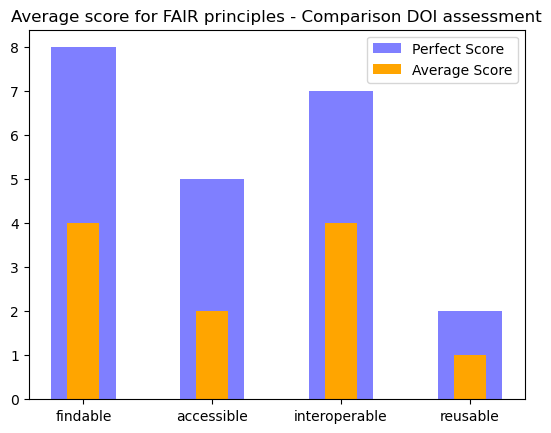

In [13]:
#plotting
width = 0.5
perfect_scores = [8, 5, 7, 2]
actual_scores = comp_doi_df_principle['avg_score']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, comp_doi_df_principle['principle'] )
plt.title("Average score for FAIR principles - Comparison DOI assessment")
plt.legend()
plt.show()

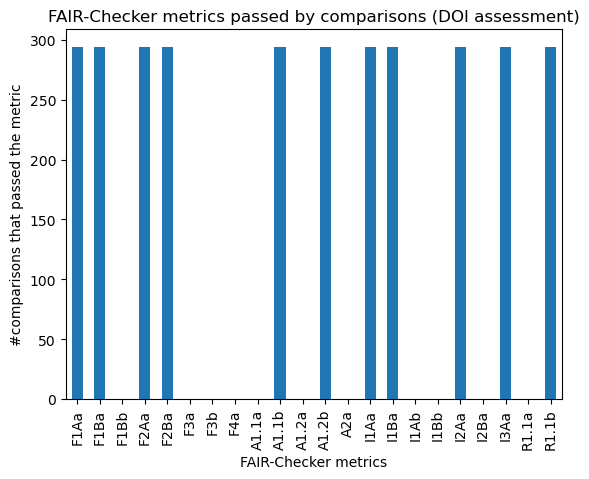

In [14]:
metric_assessment_doi_df = comp_doi_df_assessed
aggregate_funcs = {"score": "sum"}
metric_assessment_doi_df = metric_assessment_doi_df.groupby("metric").agg(aggregate_funcs).reset_index()
metric_assessment_doi_df["score"] = metric_assessment_doi_df["score"]

metric_assessment_doi_df['metric'] = pd.Categorical(metric_assessment_doi_df['metric'], ["F1Aa", "F1Ba", "F1Bb", "F2Aa", "F2Ba", "F3a", "F3b", "F4a", "A1.1a", "A1.1b", "A1.2a", "A1.2b", "A2a", "I1Aa", "I1Ba", "I1Ab", "I1Bb", "I2Aa", "I2Ba", "I3Aa", "R1.1a", "R1.1b"])
metric_assessment_doi_df = metric_assessment_doi_df.sort_values('metric')

metric_assessment_doi_df["score"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1Aa", "F1Ba", "F1Bb", "F2Aa", "F2Ba", "F3a", "F3b", "F4a", "A1.1a", "A1.1b", "A1.2a", "A1.2b", "A2a", "I1Aa", "I1Ba", "I1Ab", "I1Bb", "I2Aa", "I2Ba", "I3Aa", "R1.1a", "R1.1b"])
plt.title("FAIR-Checker metrics passed by comparisons (DOI assessment)")
plt.ylabel("#comparisons that passed the metric")
plt.xlabel("FAIR-Checker metrics")
plt.show()

## Comparisons via ORKG URL

### Comparison assessment via ORKG resource URL

In [15]:
%%script false --no-raise-error
comp_url_df = pd.read_csv("raw_data/comparison_query_result_2023-03-29.csv")
count = 0
comp_url_df["assessment_result"] = comp_url_df["comparisons"].map(lambda x: get_assessment(url=x))
comp_url_df["assessment_result"] = comp_url_df["assessment_result"].map(lambda x: get_metrics_and_scores(eval_result=x))
comp_url_df.to_csv("assessed_data/comparison_url_df_FES_assessment.csv")
comp_url_df

Couldn't find program: 'false'


### Comparison evaluation via ORKG resource URL

In [19]:
comp_url_df = pd.read_csv("assessed_data/comparison_url_df_FES_assessment.csv", index_col=0)
comp_url_df["assessment_result"] = comp_url_df["assessment_result"].map(lambda x: x.replace("\'", "\""))
comp_url_df["assessment_result"] = comp_url_df["assessment_result"].map(lambda x: json.loads(x))
comp_url_df_assessed = expand_comp_assessment_result(comp_url_df)
comp_url_df_assessed["metric"] = comp_url_df_assessed["metric"].map(lambda x: adjust_metric_names(x))
comp_url_df_assessed

,comparison,doi,metric,score
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F1Aa,1
1,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F1Ba,0
2,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F1Bb,0
3,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F2Aa,1
4,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F2Ba,1
...,...,...,...,...
25273,http://orkg.org/orkg/resource/R288673,NaN,I2Aa,0
25274,http://orkg.org/orkg/resource/R288673,NaN,I2Ba,0
25275,http://orkg.org/orkg/resource/R288673,NaN,I3Aa,0
25276,http://orkg.org/orkg/resource/R288673,NaN,R1.1a,0


In [21]:
comp_url_df_total = comp_url_df_assessed.groupby("comparison").agg({"score": "sum"}).reset_index()
print_summary_stats(comp_url_df_total["score"])

Mean: 7.0
Median: 7.0
Min: 7
Max: 7


In [22]:
comp_url_df_principle = comp_url_df_assessed
comp_url_df_principle["principle"] = comp_url_df_principle["metric"].map(lambda x: get_principle_from_metric(x))
comp_url_df_principle = comp_url_df_principle.groupby("principle").agg({"score": "sum"}).reset_index()
comp_url_df_principle["avg_score"] = comp_url_df_principle["score"]/len(comp_url_df_total)
comp_url_df_principle['principle'] = pd.Categorical(comp_url_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
comp_url_df_principle = comp_url_df_principle.sort_values('principle')
comp_url_df_principle

,principle,score,avg_score
1,findable,3447,3.0
0,accessible,2298,2.0
2,interoperable,2298,2.0
3,reusable,0,0.0


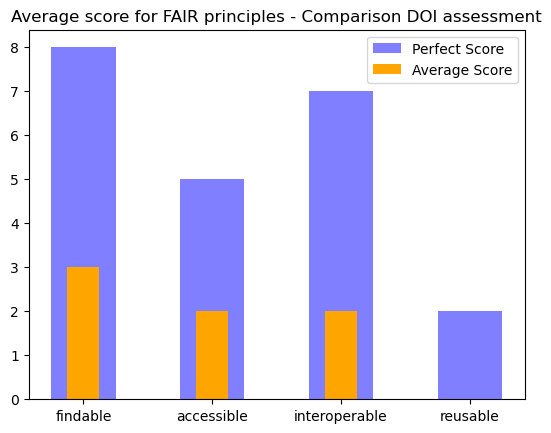

In [23]:
#plotting
width = 0.5
perfect_scores = [8, 5, 7, 2]
actual_scores = comp_url_df_principle['avg_score']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, comp_url_df_principle['principle'] )
plt.title("Average score for FAIR principles - Comparison DOI assessment")
plt.legend()
plt.show()

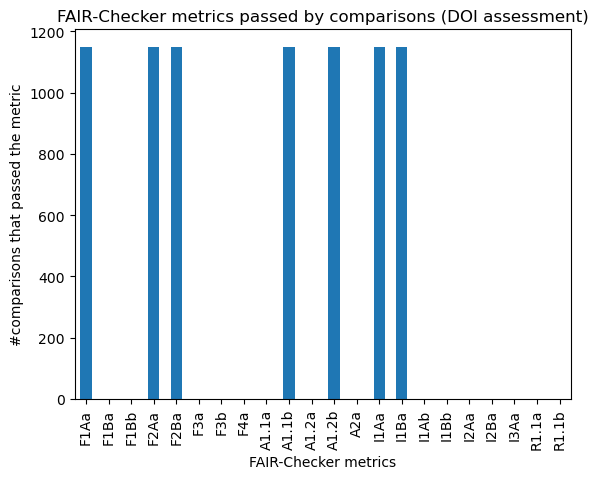

In [24]:
metric_assessment_url_df = comp_url_df_assessed
aggregate_funcs = {"score": "sum"}
metric_assessment_url_df = metric_assessment_url_df.groupby("metric").agg(aggregate_funcs).reset_index()
metric_assessment_url_df["score"] = metric_assessment_url_df["score"]

metric_assessment_url_df['metric'] = pd.Categorical(metric_assessment_url_df['metric'], ["F1Aa", "F1Ba", "F1Bb", "F2Aa", "F2Ba", "F3a", "F3b", "F4a", "A1.1a", "A1.1b", "A1.2a", "A1.2b", "A2a", "I1Aa", "I1Ba", "I1Ab", "I1Bb", "I2Aa", "I2Ba", "I3Aa", "R1.1a", "R1.1b"])
metric_assessment_url_df = metric_assessment_url_df.sort_values('metric')

metric_assessment_url_df["score"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1Aa", "F1Ba", "F1Bb", "F2Aa", "F2Ba", "F3a", "F3b", "F4a", "A1.1a", "A1.1b", "A1.2a", "A1.2b", "A2a", "I1Aa", "I1Ba", "I1Ab", "I1Bb", "I2Aa", "I2Ba", "I3Aa", "R1.1a", "R1.1b"])
plt.title("FAIR-Checker metrics passed by comparisons (DOI assessment)")
plt.ylabel("#comparisons that passed the metric")
plt.xlabel("FAIR-Checker metrics")
plt.show()

# Resources